# Wczytanie danych

In [1]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")
df_all = pd.read_csv("df_all.csv")

In [3]:
# Usunięcie 2 zmiennych, które okazały się nieistotne podczas modelowania w  Statistice
columns_to_drop = ['NAME_INCOME_TYPE', 'PREVIOUS_APPLICATION_DAYS_DECISION_MIN']

df_train = df_train.drop(columns_to_drop, axis=1)
df_test = df_test.drop(columns_to_drop, axis=1)
df_all = df_all.drop(columns_to_drop, axis=1)

Pozostało 19 zmiennych objasniających

In [4]:
df_train.shape

(452394, 20)

In [5]:
df_test.shape

(61503, 20)

In [6]:
df_all.shape

(513897, 21)

# Budowa Modeli

## 1. Model LightGBM

In [7]:
# pip install lightgbm --no-cache-dir

### Przygotowanie danych

In [8]:
import lightgbm as lgb

# Rozdzielenie cech i etykiet
X_train = df_train.iloc[:, 1:]  # wszystkie kolumny poza pierwszą
y_train = df_train.iloc[:, 0]   # pierwsza kolumna
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, 0]

In [9]:
X_train.shape

(452394, 19)

In [10]:
X_train.head(1)

,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,REGION_RATING_CLIENT,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,PREVIOUS_APPLICATION_NAME_CONTRACT_STATUS_REFUSED,POS_CASH_APP_COUNT,INSTALLMENTS_PAYMENTS_IS_DELAYED_MEAN,INSTALLMENTS_PAYMENTS_PERCENTAGE_DELAYED
0,112500.0,Secondary / secondary special,-14669,-6152.0,-4731,Security staff,2,Business Entity Type 3,0.180849,0.681706,-228,1,-1317.0,-151.0,325.333333,0.0,3.0,0.041667,10.0


In [11]:
y_train.shape

(452394,)

### Konfiguracja zbiorów danych LightGBM

LightGBM korzysta z własnego formatu danych, zwanego Dataset, który optymalizuje przechowywanie i prędkość obliczeń. Przy tworzeniu tego obiektu, można także określić, które kolumny są kategoryczne.

In [12]:
categorical_features = ['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']  # Kolumny kategoryczne

# Konwersja zmiennych kategorycznych na typ 'category', potrzebne do trenowania modelu
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

### Definiowanie parametrów modelu i trenowanie

Definiowanie parametrów modelu pozwala dostosować działanie algorytmu. Można zmieniać takie parametry jak szybkość uczenia, głębokość drzewa, metryka oceny itp.

In [13]:
params = {
    'objective': 'binary',  # typ zadania, 'binary' dla klasyfikacji binarnej
    'metric': 'auc',
    'learning_rate': 0.1,  # szybkość uczenia
    'num_leaves': 50,  # maksymalna liczba liści w drzewie
    'verbose': -1  # minimalizuje wyjście komunikatów, użyteczne przy dużych zestawach danych
}

In [14]:
# Liczba rund (iteracji)
num_round = 100

# Trenowanie modelu z użyciem danych testowych i wczesnego zatrzymywania
bst = lgb.train(params,
                train_data,
                num_boost_round=num_round,
                valid_sets=[test_data])  # Dane testowe

[1]	valid_0's auc: 0.709465
[2]	valid_0's auc: 0.720546
[3]	valid_0's auc: 0.723072
[4]	valid_0's auc: 0.724262
[5]	valid_0's auc: 0.726877
[6]	valid_0's auc: 0.729001
[7]	valid_0's auc: 0.729939
[8]	valid_0's auc: 0.73097
[9]	valid_0's auc: 0.731931
[10]	valid_0's auc: 0.732853
[11]	valid_0's auc: 0.733673
[12]	valid_0's auc: 0.734954
[13]	valid_0's auc: 0.736384
[14]	valid_0's auc: 0.737049
[15]	valid_0's auc: 0.73818
[16]	valid_0's auc: 0.738965
[17]	valid_0's auc: 0.739468
[18]	valid_0's auc: 0.740194
[19]	valid_0's auc: 0.740774
[20]	valid_0's auc: 0.741388
[21]	valid_0's auc: 0.742219
[22]	valid_0's auc: 0.743072
[23]	valid_0's auc: 0.743661
[24]	valid_0's auc: 0.744244
[25]	valid_0's auc: 0.744803
[26]	valid_0's auc: 0.745467
[27]	valid_0's auc: 0.745818
[28]	valid_0's auc: 0.746368
[29]	valid_0's auc: 0.746541
[30]	valid_0's auc: 0.747119
[31]	valid_0's auc: 0.747327
[32]	valid_0's auc: 0.747529
[33]	valid_0's auc: 0.747821
[34]	valid_0's auc: 0.748024
[35]	valid_0's auc: 0.748

### Predykcja i ocena modelu

In [15]:
# Predykcja
y_pred1 = bst.predict(X_test, num_iteration=bst.best_iteration)

In [16]:
from sklearn.metrics import roc_auc_score

# Obliczenie AUC
auc1 = roc_auc_score(y_test, y_pred1)
print(f'AUC: {auc1}')

AUC: 0.7516572919940366


In [17]:
# Obliczenie Giniego
gini1 = 2 * auc1 - 1
print(f'Gini: {gini1}')

Gini: 0.5033145839880733


In [18]:
# Obliczenie wskaźnika KS-Kołmogorowa-Smirnowa

# Przygotowanie DataFrame do obliczenia KS
df_ks = pd.DataFrame(data={
    'prob': y_pred1,
    'target': y_test
})

# Sortowanie wartości prawdopodobieństwa
df_ks = df_ks.sort_values(by='prob', ascending=True)

# Obliczanie dystrybucji skumulowanych
df_ks['cum_good'] = np.cumsum(df_ks['target'] == 0) / sum(df_ks['target'] == 0)
df_ks['cum_bad'] = np.cumsum(df_ks['target'] == 1) / sum(df_ks['target'] == 1)

# Obliczenie statystyki KS
df_ks['ks'] = np.abs(df_ks['cum_good'] - df_ks['cum_bad'])
ks_statistic = df_ks['ks'].max()

print(f'Max KS statistic: {ks_statistic}')

Max KS statistic: 0.3740272656025326


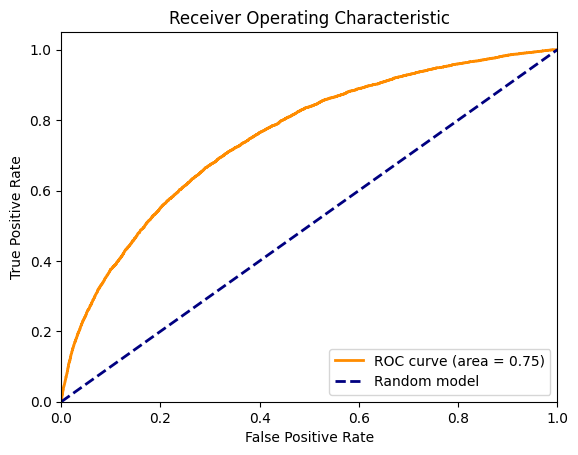

In [23]:
from sklearn.metrics import roc_curve, auc

# Przygotowanie danych do obliczenia ROC
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1)  # False Positive Rate, True Positive Rate, progi
roc_auc1 = auc(fpr1, tpr1)  # Obliczenie AUC (Area Under the Curve)

# Rysowanie krzywej ROC
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<div class="alert alert-block alert-warning"> <b>Wnioski:</b> Stworzony model został opracowany dla wszystkich 19 zmiennych objaśniających, które to zostały wybrane jako najlepsze pod względem mocy predykcyjnej i interpretowalności. Analogicznie do procesu modelowania w Statistice, aby można było je porównywać między sobą.
<br>
<br> Otrzymany model jest dość dobry i jestem zadowolony z wyników. Został oceniony pod względem miar AUC, Gini oraz testu Kołmogorowa-Smirnowa (KS). Tak przedstawiają się wyniki statystyk:
<br> * AUC = 0,7516
<br> * Gini = 0,5033
<br> * KS = 0,3740

Wszystkie powyższe wskaźniki jasno przedstawiają, że model jest dość dobry, żeby wdrożyć go na produkcję.

## 2. Model XGBoost

In [24]:
# pip install xgboost

### Przygotowanie danych

Podobnie jak w przypadku LightGBM, przygotowujemy dane dzieląc je na cechy i etykiety

In [25]:
import xgboost as xgb

# Tworzenie zbiorów DMatrix, które są optymalne dla XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

### Definiowanie parametrów modelu i trenowanie

In [26]:
params2 = {
    'objective': 'binary:logistic',  # cel dla klasyfikacji binarnej
    'max_depth': 6,  # maksymalna głębokość drzew
    'learning_rate': 0.1,  # szybkość uczenia
    'eval_metric': 'auc',  # metryka do oceny modelu
    'min_child_weight': 1,  # minimalna suma wagi potrzebna w węźle
    'subsample': 0.8,  # procent próbek używanych na drzewo
    'colsample_bytree': 0.8,  # procent cech używanych na drzewo
    'seed': 42  # ziarno dla reprodukowalności
}

In [27]:
num_rounds = 100  # liczba rund (iteracji) boostingu
evallist = [(dtest, 'eval'), (dtrain, 'train')]  # lista zestawów do oceny

bst2 = xgb.train(params2, dtrain, num_rounds, evallist, early_stopping_rounds=10, verbose_eval=True)

[0]	eval-auc:0.71397	train-auc:0.72316
[1]	eval-auc:0.71925	train-auc:0.73238
[2]	eval-auc:0.72138	train-auc:0.73877
[3]	eval-auc:0.72146	train-auc:0.74175
[4]	eval-auc:0.72297	train-auc:0.74338
[5]	eval-auc:0.72287	train-auc:0.74548
[6]	eval-auc:0.72720	train-auc:0.74989
[7]	eval-auc:0.72956	train-auc:0.75249
[8]	eval-auc:0.73101	train-auc:0.75447
[9]	eval-auc:0.73180	train-auc:0.75608
[10]	eval-auc:0.73283	train-auc:0.75743
[11]	eval-auc:0.73385	train-auc:0.75949
[12]	eval-auc:0.73450	train-auc:0.76105
[13]	eval-auc:0.73612	train-auc:0.76236
[14]	eval-auc:0.73674	train-auc:0.76378
[15]	eval-auc:0.73723	train-auc:0.76491
[16]	eval-auc:0.73752	train-auc:0.76599
[17]	eval-auc:0.73812	train-auc:0.76765
[18]	eval-auc:0.73850	train-auc:0.76864
[19]	eval-auc:0.73910	train-auc:0.77006
[20]	eval-auc:0.73992	train-auc:0.77097
[21]	eval-auc:0.74029	train-auc:0.77191
[22]	eval-auc:0.74070	train-auc:0.77283
[23]	eval-auc:0.74164	train-auc:0.77383
[24]	eval-auc:0.74211	train-auc:0.77515
[25]	eval-

### Predykcja i ocena modelu

In [28]:
# Predykcja
y_pred2 = bst2.predict(dtest)

In [29]:
# Obliczenie AUC

auc2 = roc_auc_score(y_test, y_pred2)
print(f'AUC: {auc2}')

AUC: 0.7489677930808236


In [30]:
# Obliczenie Giniego
gini2 = 2 * auc2 - 1
print(f'Gini: {gini2}')

Gini: 0.49793558616164724


In [31]:
# Obliczenie wskaźnika KS-Kołmogorowa-Smirnowa

# Przygotowanie DataFrame do obliczenia KS
df_ks = pd.DataFrame(data={
    'prob': y_pred2,
    'target': y_test
})

# Sortowanie wartości prawdopodobieństwa
df_ks = df_ks.sort_values(by='prob', ascending=True)

# Obliczanie dystrybucji skumulowanych
df_ks['cum_good'] = np.cumsum(df_ks['target'] == 0) / sum(df_ks['target'] == 0)
df_ks['cum_bad'] = np.cumsum(df_ks['target'] == 1) / sum(df_ks['target'] == 1)

# Obliczenie statystyki KS
df_ks['ks'] = np.abs(df_ks['cum_good'] - df_ks['cum_bad'])
ks_statistic = df_ks['ks'].max()

print(f'Max KS statistic: {ks_statistic}')

Max KS statistic: 0.36959954567332554


<div class="alert alert-block alert-warning"> <b>Wnioski:</b> Stworzony model podobnie jak wcześniej LGBM został opracowany dla wszystkich 19 zmiennych objaśniających, które to zostały wybrane jako najlepsze pod względem mocy predykcyjnej i interpretowalności.
<br>
<br> Otrzymany model ponownie jest dysyć dobry, natomiast jest nieznacznie gorszy niż LightGBM. Tak przedstawiają się wyniki statystyk:
<br> * AUC = 0,7490
<br> * Gini = 0,4979
<br> * KS = 0,3696

# Wykres Gini dla obu modeli

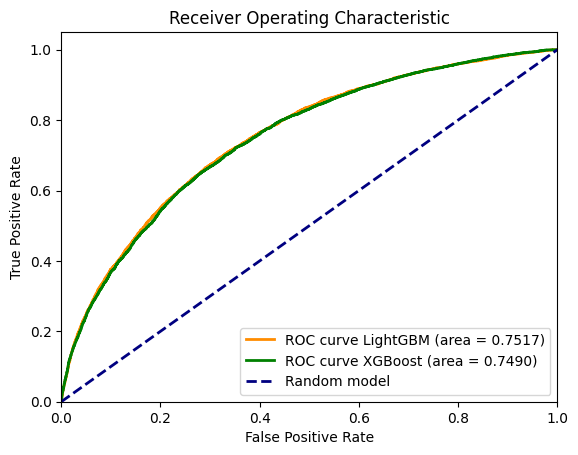

In [36]:
from sklearn.metrics import roc_curve, auc

# Przygotowanie danych do obliczenia ROC
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1)  # False Positive Rate, True Positive Rate, progi
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)  # False Positive Rate, True Positive Rate, progi
roc_auc1 = auc(fpr1, tpr1)  # Obliczenie AUC (Area Under the Curve)
roc_auc2 = auc(fpr2, tpr2)  # Obliczenie AUC (Area Under the Curve)

# Rysowanie krzywej ROC
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve LightGBM (area = {roc_auc1:.4f})')
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'ROC curve XGBoost (area = {roc_auc2:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()